Mount Github files to Google Drive

In [1]:
! rm -rf sample_data; curl -s https://raw.githubusercontent.com/DayongTong/MEAM517_Project_Git/main/sync_project.py > sync_project.py
files = ["spacecraft.py","simulation.py", "dynamic_constraints.py", "kinematic_constraints.py","plot_util.py","logger_util.py","dirtrel.py"]

from sync_project import sync_project
sync_project(files, False)

Mounted at /content/drive


Install Drake

In [2]:
# install pydrake

!curl -s https://raw.githubusercontent.com/mposa/MEAM517/master/colab_drake_setup.py > colab_drake_setup.py
from colab_drake_setup import setup
setup()

<IPython.core.display.Javascript object>

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  205M  100  205M    0     0  68.1M      0  0:00:03  0:00:03 --:--:-- 68.1M
Reading package lists...
Building dependency tree...
Reading state information...
libdouble-conversion1 is already the newest version (2.0.1-4ubuntu1).
libdouble-conversion1 set to manually installed.
libglu1-mesa is already the newest version (9.0.0-2.1build1).
libglu1-mesa set to manually installed.
libjsoncpp1 is already the newest version (1.7.4-3).
libjsoncpp1 set to manually installed.
liblapack3 is already the newest version (3.7.1-4ubuntu1).
liblapack3 set to manually installed.
liblz4-1 is already the newest version (0.0~r131-2ubuntu3).
liblzma5 is already the newest version (5.2.2-1.3).
libogg0 is already the newest version (1.3.2-1).
libogg0 set to manually installed.
libtheora0 is already the newest version (1.1.1+dfsg.1-14).
libtheora0 set 

Import Packages

In [3]:
from pydrake.all import eq, MathematicalProgram, Solve, Variable
import matplotlib.pyplot as plt
import numpy as np
import importlib
from pydrake.math import sqrt
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve, SolverType
from pydrake.trajectories import PiecewisePolynomial
from pydrake.solvers.snopt import SnoptSolver
from pydrake.autodiffutils import AutoDiffXd
import pydrake.math as drake_math

In [36]:
import kinematic_constraints
import dynamic_constraints
import plot_util
import logger_util
import dirtrel
importlib.reload(plot_util)
importlib.reload(kinematic_constraints)
importlib.reload(dynamic_constraints)
importlib.reload(logger_util)
importlib.reload(dirtrel)
from kinematic_constraints import (
    AddInitialConstraints,
    AddLandingConstraints
)
from dynamic_constraints import (
    AddCollocationConstraints,
    EvaluateDynamics,
    numeric_eval_dynamics
)
from plot_util import(
    plot_util,
    plot_util_spline,
    plot_3d_trajectory,
    plot_util_overlay
)
from logger_util import logger_util
from dirtrel import (
    ell_w,
    compute_A,
    compute_B,
    compute_G
)

In [6]:
# set up constants

N = 25                     # number of collocation points
n_x = 9
n_u = 3

r_0 = 3474.8*1000           #radius of Mars (m)
alpha_0 = -23.45*np.pi/180  #longitude 
beta_0 = -2.94*np.pi/180    #latitude 
Vx_0 = 0
Vy_0 = 0
Vz_0 = 0
m_0 = 4000 #15234                  #Mass of rocket (kg)
phi_0 = 90*np.pi/180         #pitch 
psi_0 = 0                    #yaw 

# final position
r_N = 3474.8*1000            #radius of Mars, in km
alpha_N = -23.45*np.pi/180   
beta_N = -2.34*np.pi/180     
Vx_N = 0
Vy_N = 0
Vz_N = 0
phi_N = 90*np.pi/180
psi_N = 0

# initial control input 
T_0 = 0
phidot_0 = 0
psidot_0 = 0

# final control input
T_N = 0
phidot_N = 0
psidot_N = 0

# constraint coefficients
r_min = 3474.8*1000
h_max = 30
r_max = 3474.8*1000 + h_max   #h_max km above Mars surface
phi_min = -180*np.pi/180   #rad
phi_max = 180*np.pi/180    #rad
psi_min = -180*np.pi/180   #rad
psi_max = 180*np.pi/180    #rad
phidot_min = -10*np.pi/180 #rad/sec
phidot_max = 10*np.pi/180  #rad/sec
psidot_min = -10*np.pi/180 #rad/sec
psidot_max = 10*np.pi/180  #rad/sec
T_min = 4671               #Newton
T_max = 43148              #Newton

initial_state = np.array([r_0,alpha_0,beta_0,Vx_0,Vy_0,Vz_0,m_0,phi_0,psi_0])
final_state = np.array([r_N,alpha_N,beta_N,Vx_N,Vy_N,Vz_N,phi_N,psi_N])
input_limit = np.array([[T_min,phidot_min,psidot_min],[T_max,phidot_max,psidot_max]])
initial_input = np.array([T_0,phidot_0,psidot_0])
final_input = np.array([T_N,phidot_N,psidot_N])

# m = 8321.09        #kg
g = 3.711          #m/s^2
Isp = 302.39       #s (effective specific impulse of the lander, used in mdot equation)


In [7]:
# Initialize Mathematical Program and Add Variables

prog = MathematicalProgram()
x = np.zeros((N,n_x),dtype="object")
u = np.zeros((N,n_u),dtype="object")
dt = np.zeros((1,), dtype="object")

for i in range(N):
    x[i] = prog.NewContinuousVariables(n_x,"x_" + str(i))
    u[i] = prog.NewContinuousVariables(n_u,"u_" + str(i))
dt = prog.NewContinuousVariables(1,"dt") 

t0 = 0.0

In [8]:
def compute_A(x, u, w, i):
    r = x[:,0]
    alpha = x[:,1]
    beta = x[:,2]
    Vx = x[:,3]
    Vy = x[:,4]
    Vz = x[:,5]
    m = x[:,6]
    phi = x[:,7]
    psi = x[:,8]

    T = u[:,0]
    omega_phi = u[:,1]
    omega_psi = u[:,2]
    A = np.array([  [0,0,0,1,0,0,0,0,0],
                    [-Vy[i]/(r[i]**2*drake_math.cos(beta[i])), 				0,	Vy[i]*drake_math.sin(beta[i])/(r[i]*drake_math.cos(beta[i])**2), 	0, 		1/(r[i]*drake_math.cos(beta[i])), 		0, 				0, 							0, 						0],
                    [-Vz[i]/r[i]**2, 							0, 	0, 								0, 		0, 						1/r[i], 			0, 							0, 						0],
                    [-(Vy[i]**2+Vz[i]**2)/r[i]**2, 				0, 	0, 								0, 		2*Vy[i]/r[i], 				2*Vz[i]/r[i], 		-T[i]*drake_math.sin(phi[i])/(m[i]+w)**2, 			T[i]*drake_math.cos(phi[i])/(m[i]+w), 			0],
                    [Vx[i]*Vy[i]/r[i]**2-Vy[i]*Vz[i]*drake_math.tan(beta[i])/r[i]**2,	0,	Vy[i]*Vz[i]*(1+drake_math.tan(beta[i])**2)/r[i], 		-Vy[i]/r[i],	-Vx[i]/r[i]+Vz[i]*drake_math.tan(beta[i])/r[i],	Vy[i]*drake_math.tan(beta[i])/r[i],	-T[i]*drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w)**2,	-T[i]*drake_math.sin(phi[i])*drake_math.cos(psi[i])/(m[i]+w),	-T[i]*drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w)],
                    [Vx[i]*Vz[i]/r[i]**2+Vy[i]**2*drake_math.tan(beta[i])/r[i]**2, 	0, 	-Vy[i]**2*(1+drake_math.tan(beta[i])**2)/r[i], 		-Vz[i]/r[i], 	-2*Vy[i]*drake_math.tan(beta[i])/r[i], 		-Vx[i]/r[i], 			-T[i]*drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w)**2,	-T[i]*drake_math.sin(phi[i])*drake_math.sin(psi[i])/(m[i]+w),	T[i]*drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w)],
                    [0, 0, 0, 0, 0, 0, 0, 0,0],
                    [0, 0, 0, 0, 0, 0, 0, 0,0],
                    [0, 0, 0, 0, 0, 0, 0, 0,0]])

    return A

def compute_B(x, u, w, i):

    m = x[:,6]
    phi = x[:,7]
    psi = x[:,8]

    B = np.array([  [0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0],
                    [drake_math.sin(phi[i])/(m[i]+w), 0, 0],
                    [drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w), 0, 0],
                    [drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w), 0, 0],
                    [-1/(Isp*g), 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]])
    return B

def compute_G(x, u, w, i):
    m = x[:,6]
    phi = x[:,7]
    psi = x[:,8]
    T = u[:,0]
    G = np.array([ [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,-T[i]*drake_math.sin(phi[i])/(m[i]+w)**2,0,0],
                   [0,0,0,0,0,0,-T[i]*drake_math.cos(phi[i])*drake_math.cos(psi[i])/(m[i]+w)**2,0,0],
                   [0,0,0,0,0,0,-T[i]*drake_math.cos(phi[i])*drake_math.sin(psi[i])/(m[i]+w)**2,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0]])
    return G

def ell_w(x, u, D, E_1, Q_l, R_l, Ql_n, Q, R, N):
    
    ell = 0
    w = 20*np.random.rand() # [0, 1)
    A = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)
    B = np.zeros((N,n_x,n_u), dtype=AutoDiffXd)
    G = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)

    K = [0]*(N-1)

    K = np.zeros((N-1,n_u,n_x), dtype=AutoDiffXd)    
    E = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)    
    H = np.zeros((N,n_x,n_x), dtype=AutoDiffXd)    
    for i in range(N):
        A[i] = compute_A(x, u, w, i)
        B[i] = compute_B(x, u, w, i)
        G[i] = compute_G(x, u, 0, i)
    P = [0]*N
    P[-1] = Ql_n
    
    # compute Riccati difference equation for i in 1:N
    for i in reversed(range(1,N)):
        P[i-1] = Q + A[i].T@P[i]@A[i]-A[i].T@P[i]@B[i]@(R + B[i].T@P[i]@B[i]).T@(B[i].T@P[i]@A[i])
    for i in range(N-1):
        K[i] = (R + B[i].T@P[i+1]@B[i]).T@(B[i].T@P[i+1]@A[i])
    
    H[0] = np.zeros_like(Q)
    E[0] = E_1
    for i in range(N-1):
        ell += np.trace((Q_l + K[i].T @ R_l @ K[i]) @ E[i])
        E[i+1] = (A[i] - B[i] @ K[i]) @ E[i] @ (A[i] - B[i] @ K[i]).T + \
                 (A[i] - B[i] @ K[i]) @ H[i] @ G[i].T + \
                  G[i] @ H[i].T @  (A[i] - B[i] @ K[i]).T + G[i] @ D @ G[i].T
        H[i+1] =  (A[i] - B[i] @ K[i]) @ H[i] + G[i] @ D
    ell += np.trace(Ql_n @ E[-1])
    return ell

def AddCost(x, u, use_dirtrel=False):
    TT = 0
    for i in range(N-1):
        TT += (u[i,0]**2 + u[i+1,0]**2)
    if use_dirtrel == False:
        prog.AddQuadraticCost(TT)
    else:
        D = 20*np.eye(9)
        E_1 = np.eye(9)
        R = 10*np.eye(3)
        Q = 10*np.eye(9)
        # TT += ell_w(x, u, D, E_1, Q, R,Q,Q,R,N,0,6)
        TT += ell_w(x, u, D, E_1, Q, R,Q,Q,R,N)
        prog.AddCost(TT)


In [9]:
def addDirtrelCost(prog,x,u,D,E_1,Q_l,R_l,Ql_n,Q,R,N):

    def addCostHelper(vars):
        # print(vars)
        # print('in')
        xvar = np.zeros((N,n_x),dtype=AutoDiffXd)
        uvar = np.zeros((N,n_u),dtype=AutoDiffXd)
        # TT_autodiff = np.zeros((1,),dtype=AutoDiffXd)
        # TT_autodiff = TT
        for i in range(n_x+n_u):
            # print(i)
            if i < n_x:
                xvar[:,i] = vars[i*N:(i+1)*N]
            else:
                uvar[:,i-n_x] = vars[i*N:(i+1)*N]
        return ell_w(xvar,uvar,D,E_1,Q_l,R_l,Ql_n,Q,R,N) #xvar, uvar?

    flat = np.hstack((np.hstack((x,u))[:,0:9].flatten('F'),np.hstack((x,u))[:,9:12].flatten('F')))
    # print(flat)
    flat = flat.reshape((N*(n_x+n_u),1))
    prog.AddCost(addCostHelper,flat)

def AddQuadCost(vars):
    TT = 0
    uvar = np.zeros((N, n_u), dtype=AutoDiffXd)
    for i in range(n_u):
        uvar[:,i] = vars[i*N:(i+1)*N]
    
    for i in range(N-1):
        TT += (uvar[i,0]**2 + uvar[i+1,0]**2)
    # print('TT',TT)
    return TT


def AddProgCost(x, u, use_dirtrel=False):
    # TT = 0
    # for i in range(N-1):
    #     TT += (u[i,0]**2 + u[i+1,0]**2)
    if use_dirtrel == False:
        prog.AddCost(AddQuadCost, vars= np.hstack(u.flatten('F')))

    else:
        D = 20*np.eye(9)
        E_1 = np.eye(9)
        R = 10*np.eye(3)
        Q = 10*np.eye(9)
        # TT += ell_w(x, u, D, E_1, Q, R,Q,Q,R,N)
        print("cost")
        prog.AddCost(AddQuadCost, vars = np.hstack(u.flatten('F')))
        print("added cost successfully")
        addDirtrelCost(prog,x,u,D,E_1,Q,R,Q,Q,R,N)


In [10]:
# cost
# True means using Dirtrel, False means regular dircon
# run the LQR block at the bottom first before this block, error is fine
AddProgCost(x,u,False)

In [11]:
# Add dynamic constraint
AddCollocationConstraints(prog, N, x, u, dt)

# Add kinematic initial and final(landing) constraint
AddInitialConstraints(prog, N, x, u, initial_state, initial_input)
AddLandingConstraints(prog, N, x, u, final_state, final_input)

In [12]:
# Add input/state limitation as bounding box constraints

# height limit: 0 <= h <= hmax
prog.AddBoundingBoxConstraint(r_min, r_max, x[:,0])
# mass limits
prog.AddBoundingBoxConstraint(0, m_0, x[:,6])
for i in range(N-1):
  prog.AddLinearConstraint(x[i+1, 6] <= x[i, 6])

# angular position input limit
prog.AddBoundingBoxConstraint(phi_min, phi_max, x[:,7]) 
prog.AddBoundingBoxConstraint(psi_min, psi_max, x[:,8])
prog.AddBoundingBoxConstraint(0, T_max, u[:,0])# change constraint

# thrust input limit
# f1 = (u[:,0] - T_min)*(0.65*T_max - u[:,0])
# f2 = (u[:,0] - T_min)*(T_max - u[:,0])
# F = f1 + f2 + np.sqrt(f1**2 + f2**2)
# for i in range(N):
    # prog.AddConstraint(F[i] >= 0)


# omega angular velocity state limits
prog.AddBoundingBoxConstraint(phidot_min, phidot_max, u[:,1])
prog.AddBoundingBoxConstraint(psidot_min, psidot_max, u[:,2])

In [13]:
# Set up solver initial guess

# state initial guess
xinit = np.zeros((N,n_x))

# altitude initial guess
a1 = np.linspace(r_0,r_0+6,N-N//2)
a2 = np.linspace(r_0+5,r_0,N//2)
xinit[:,0] = np.concatenate((a1,a2),axis=0)

# longitude initial guess
a1 = np.linspace(alpha_0,-23.47*np.pi/180,N-N//2)
a2 = np.linspace(-23.46*np.pi/180,alpha_N,N//2)
xinit[:,1] = np.concatenate((a1,a2),axis=0)

# latitude initial guess
xinit[:,2] = np.linspace(beta_0,beta_N,N)

# velocity Vx
a1 = np.linspace(Vx_0,100,N//5)
a2 = np.linspace(100,-100,N-2*N//5)
a3 = np.linspace(-100,Vx_N,N//5)
xinit[:,3] = np.concatenate((a1,a2,a3),axis=0)

# velocity Vy no need to do anything, all zeros is a good guess

# velocity Vz
a1 = np.linspace(Vz_0,150,N-N//2)
a2 = np.linspace(140,Vz_N,N//2)
xinit[:,5] = np.concatenate((a1,a2),axis=0)
# mass

# xinit[:,6] = np.array([4000.        , 3986.64017092, 3973.28034183, 3968.1998802 ,
#        3958.26536038, 3948.78736338, 3939.76618855, 3931.20309371,
#        3927.03159841, 3923.31696448, 3916.12807295, 3909.39846035,
#        3903.12980393, 3886.75103722, 3873.39120841])
xinit[:,6] = np.linspace(4000,3873,N)

# pitch phi Need Halp
xinit[:,7] = np.full(N,phi_0)

# yaw psi
xinit[:,8] = np.full(N,psi_0)

# input initial guess
uinit = np.zeros((N,n_u))
for i in range(n_u):
#   if i == 0:
    # uinit[:3,i] = input_limit[1, i]/2*np.ones(3)
    # uinit[3:,i] = np.zeros(N-3)
  uinit[:,i] = np.random.uniform(input_limit[0,i],input_limit[1,i],N)

tinit = 1
prog.SetInitialGuess(u,uinit)
prog.SetInitialGuess(x,xinit)
prog.SetInitialGuess(dt, [tinit])

In [14]:
# set up solver
solver = SnoptSolver()
prog.SetSolverOption(SolverType.kSnopt, "Iterations limit", 1000000)
result = solver.Solve(prog)
print(result.get_solution_result())
# get solution of states and inputs from solver result
x_sol = result.GetSolution(x)
u_sol = result.GetSolution(u)
t_sol = result.GetSolution(dt)


timesteps = np.linspace(t0, t_sol*N, N)
xdot_sol = np.zeros(x_sol.shape)
for i in range(N):
    xdot_sol[i] = EvaluateDynamics(x_sol[i], u_sol[i])

# create trajectory by interpolating between collocation points using piecewise polynomial
x_traj = PiecewisePolynomial.CubicHermite(timesteps, x_sol.T, xdot_sol.T)
u_traj = PiecewisePolynomial.FirstOrderHold(timesteps, u_sol.T)


SolutionResult.kSolutionFound


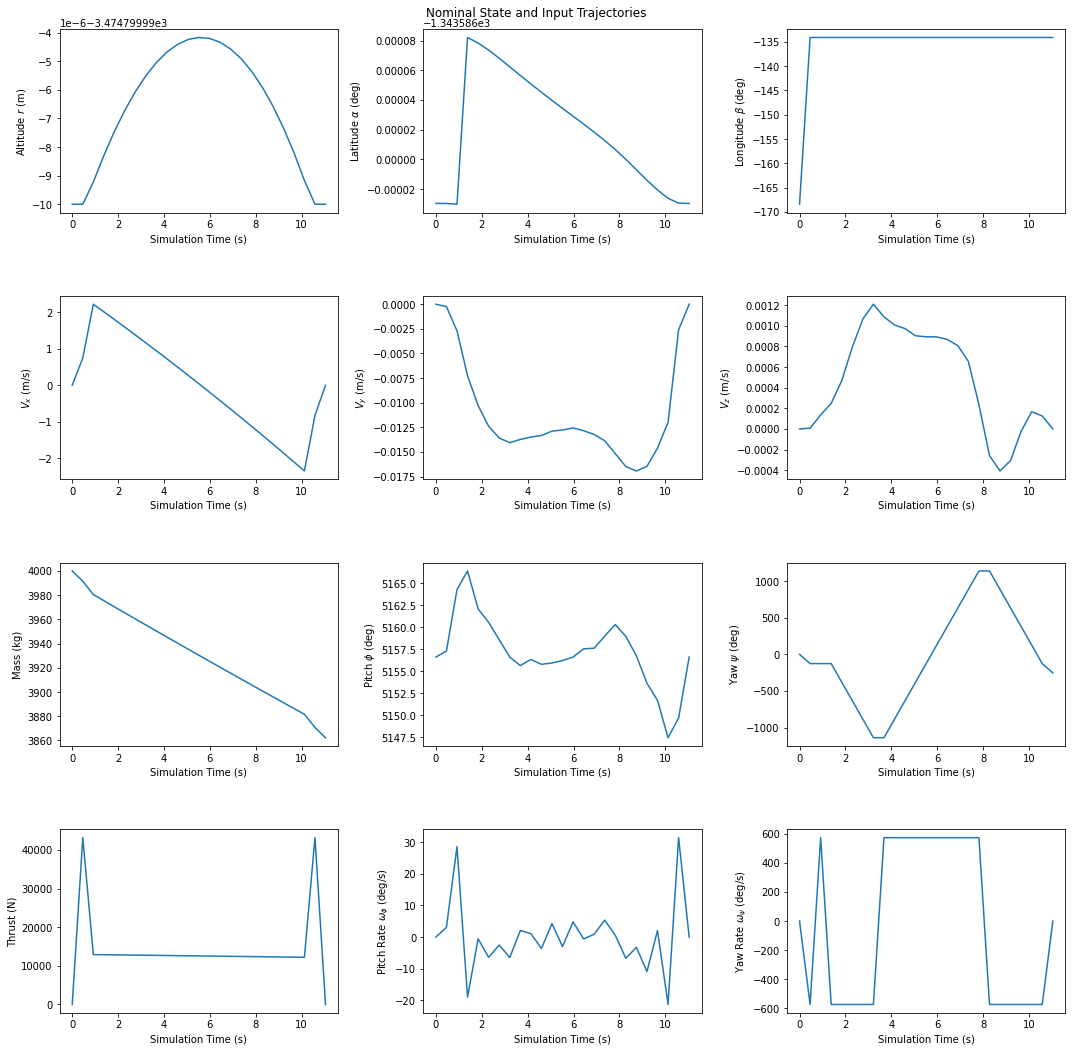

In [24]:
x_sol_plot = x_sol
u_sol_plot = u_sol
x_sol_plot[:,0] -= r_min
x_sol_plot[:,0] /= 1000
x_sol_plot[:,1] *= 180/np.pi
x_sol_plot[:,2] *= 180/np.pi
x_sol_plot[:,7] *= 180/np.pi
x_sol_plot[:,8] *= 180/np.pi
u_sol_plot[:,1] *= 180/np.pi
u_sol_plot[:,2] *= 180/np.pi
plot_util(timesteps, x_sol_plot, u_sol_plot,n_x)

In [16]:
print("Total mass lost:", xinit[N-1, 6] - x_sol[N-1, 6], "kg")
print("Optimal dt: ", t_sol)

Total mass lost: 10.767722656838032 kg
Optimal dt:  [0.44160284]


Text(0.5, 0, 'Simulation time (s)')

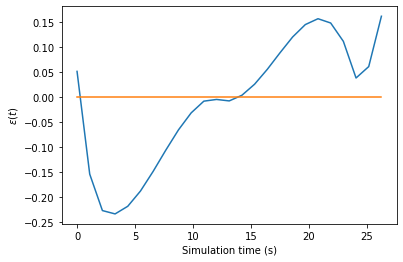

In [ ]:
# numerically evaluate dynamics by passing in a continuous polynomial trajectory

# which state to print in the error plot
state_to_plot = 0

vals = []
for i in range(1, int(N*t_sol[0])):
    vals.append(x_traj.derivative(1).value(i)[state_to_plot].item())

densetimesteps = np.linspace(0,N*t_sol[0],len(vals))
x_traj_dot = numeric_eval_dynamics(x_traj,u_traj,t_sol[0],N)

# plt.plot(densetimesteps,vals)
# plt.plot(densetimesteps,x_traj_dot[:,0])

eps = []
for i in range(len(vals)):
    eps.append(vals[i] - x_traj_dot[:,state_to_plot][i])

plt.plot(densetimesteps, eps)
plt.plot(densetimesteps, np.zeros_like(densetimesteps))
plt.ylabel(r"$\epsilon(t)$")
plt.xlabel("Simulation time (s)")

In [ ]:
# logger_util(t_sol, x_sol, u_sol, tinit, xinit, uinit)

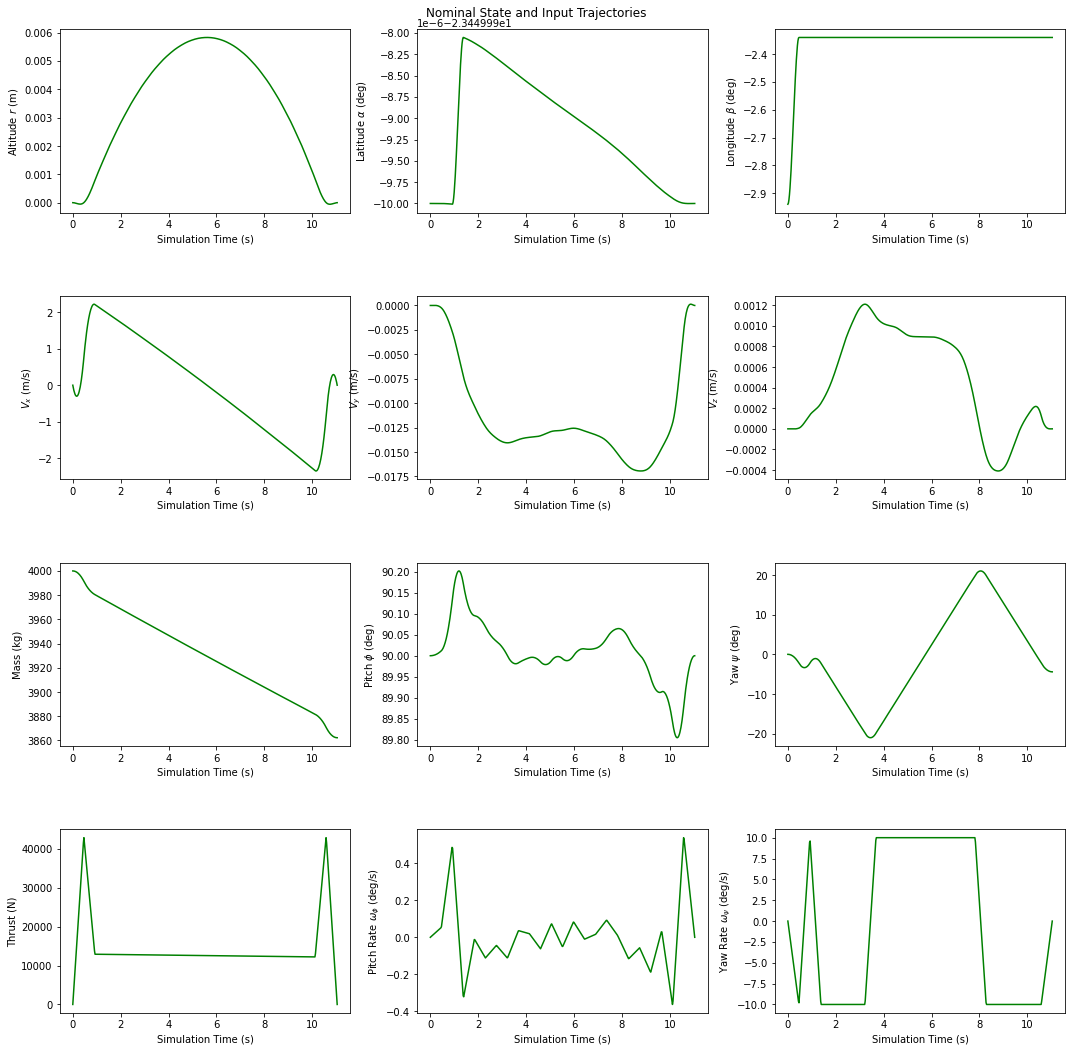

In [17]:
plot_util_spline(N, t_sol, x_traj, u_traj, n_x, r_min)

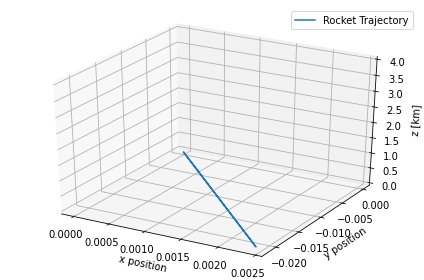

In [ ]:
plot_3d_trajectory(x_sol[:,0],x_sol[:,1],x_sol[:,2])

In [ ]:
def plot_util(timesteps, x_sol, u_sol):
  fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
  fig.subplots_adjust(hspace=10)
  fig.suptitle('Nominal State and Input Trajectories')
  labels = ['Altitude $r$ (km)', r'Latitude $\alpha$ (deg)', r'Longitude $\beta$ (deg)',
            '$V_x$ (m/s)', '$V_y$ (m/s)', '$V_z$ (m/s)',
            'Mass (kg)', r'Pitch $\phi$ (deg)', r'Yaw $\psi$ (deg)',
            'Thrust (N)', r'Pitch Rate $\omega_{\phi}$ (deg/s)', r'Yaw Rate $\omega_{\psi}$ (deg/s)']

  for idx, ax in enumerate(axes.flatten()):
    if idx < n_x:
      ax.plot(timesteps, x_sol[:,idx])
    else:
      ax.plot(timesteps, u_sol[:,idx % n_x])
    ax.set(ylabel = labels[idx])
    ax.set(xlabel = "Simulation Time (s)")

  plt.tight_layout()

def plot_util_spline(N, t_sol, x_s, u_s):
  fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
  fig.subplots_adjust(hspace=10)
  fig.suptitle('Nominal State and Input Trajectories')
  labels = ['Altitude $r$ (km)', r'Latitude $\alpha$ (deg)', r'Longitude $\beta$ (deg)',
            '$V_x$ (m/s)', '$V_y$ (m/s)', '$V_z$ (m/s)',
            'Mass (kg)', r'Pitch $\phi$ (deg)', r'Yaw $\psi$ (deg)',
            'Thrust (N)', r'Pitch Rate $\omega_{\phi}$ (deg/s)', r'Yaw Rate $\omega_{\psi}$ (deg/s)']
  
  for idx, ax in enumerate(axes.flatten()):
    if idx < n_x:
      vals = []
      for i in range(int(N*t_sol[0])):
        vals.append(x_s.value(i)[idx])
        ax.plot(vals)
    else:
      vals = []
      for i in range(int(N*t_sol[0])):
        vals.append(u_s.value(i)[idx % n_x])
        ax.plot(vals)
    ax.set(ylabel = labels[idx])
    ax.set(xlabel = "Simulation Time (s)")

  plt.tight_layout()

In [ ]:
def logger_util(t_sol, x_sol, u_sol, tinit, xinit, uinit):
    x_labels = ["r: ", "alpha: ", "beta: ", 
              "Vx: ", "Vy: ", "Vz: ",
              "m: ", "phi: ", "psi: "]
    u_labels = ["T: ", "w_phi: ", "w_psi: "]       
    with open("save_solution_variables.txt", mode='w') as F:
        F.write("LOGGING SOLUTIONS... \n")
        F.write("t_sol: ")
        F.write(t_sol[0].astype(str))
        F.write("\n")
        for idx, label in enumerate(x_labels):
            F.write(label)
            F.write(str(x_sol[:,idx]))
            F.write("\n")
        for idx, label in enumerate(u_labels):
            F.write(label)
            F.write(str(u_sol[:,idx]))
            F.write("\n")

        F.write("LOGGING INITIAL GUESSES...\n")
        F.write("Time Initial Guess: ")
        F.write(str(tinit))
        F.write("\n")
        F.write("State Initial Guess: ")
        F.write(str(xinit))
        F.write("\n")
        F.write("Input Initial Guess: ")
        F.write(str(uinit))

In [ ]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

def plot_3d_trajectory(r_sol, alpha_sol, beta_sol, T_sol=None):
  import matplotlib as mpl
  from mpl_toolkits.mplot3d import Axes3D
  import numpy as np
  import matplotlib.pyplot as plt
  mpl.rcParams['legend.fontsize'] = 10
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  x = r_sol*np.sin(beta_sol)*np.cos(alpha_sol)
  y = r_sol*np.sin(beta_sol)*np.sin(alpha_sol)
  z = r_sol*np.cos(beta_sol)
  ax.plot(x, y, z, label='Rocket Trajectory')
  ax.set_xlabel('x position')
  ax.set_ylabel('y position')
  ax.set_zlabel('z [km]')  
  ax.set_zlim(0,4)
  ax.legend()
  plt.tight_layout()
  plt.show()


In [40]:
# TODO: create LQR to follow the trajectory
import spacecraft
importlib.reload(spacecraft)
from spacecraft import Spacecraft

import simulation
importlib.reload(simulation)
from simulation import simulate_spacecraft

In [80]:
R = 10*np.eye(3)
Q = 10*np.eye(9)
Q = np.zeros((9, 9), int)
np.fill_diagonal(Q, [10,10,10,10,500,1000,1,1000,10])
R = np.zeros((3,3),int)
np.fill_diagonal(R,[1,500,3])

Qf = Q
spacecraft = Spacecraft(Q,R,Qf,t_sol.item()*N,x_traj,u_traj)
xsim,usim,tsim = simulate_spacecraft(x_traj.value(0).flatten(),u_traj.value(0).flatten(),t_sol.item()*N,spacecraft,[0.01,0.5],[3,6])

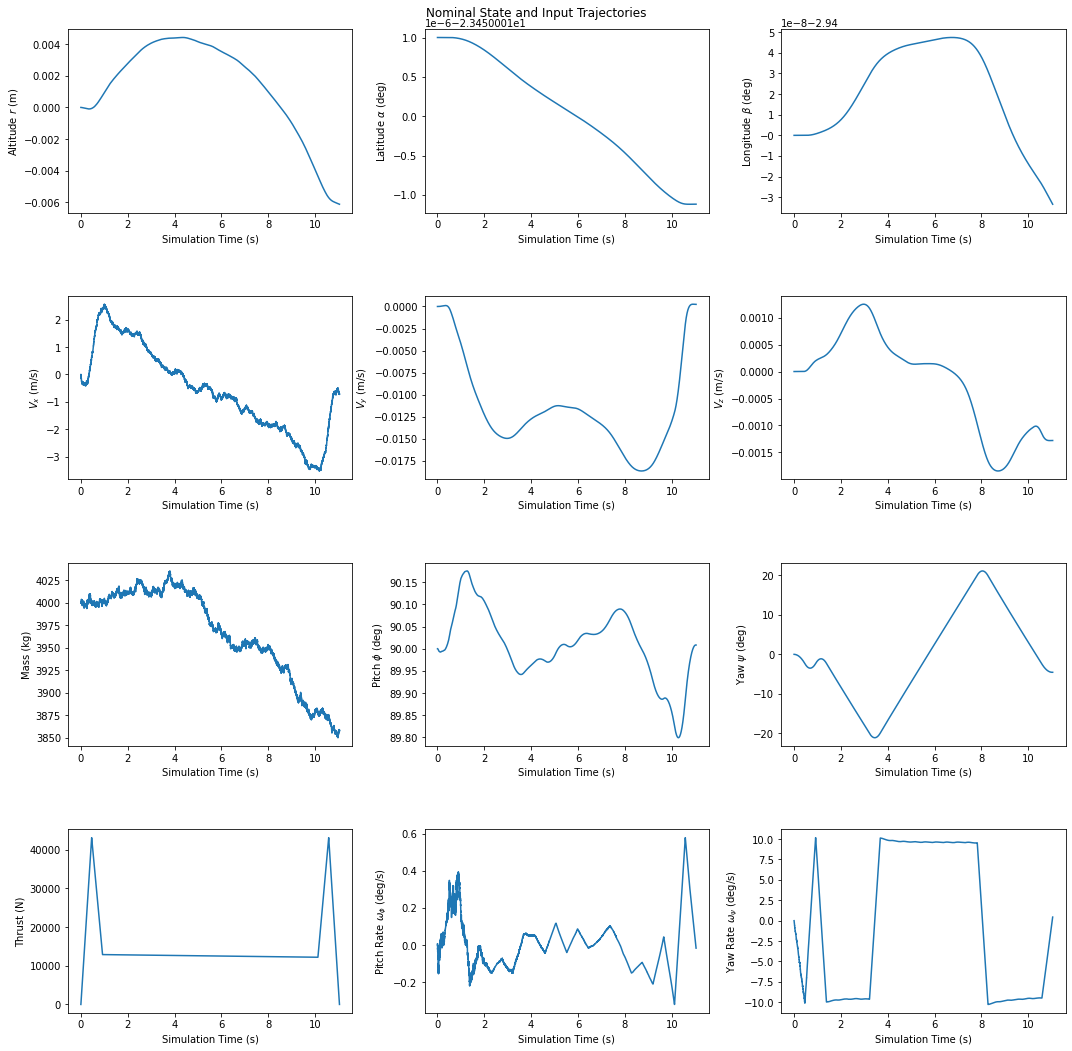

In [81]:
x_sim_plot = xsim
u_sim_plot = usim
x_sim_plot[:,0] -= r_min
x_sim_plot[:,0] /= 1000
x_sim_plot[:,1] *= 180/np.pi
x_sim_plot[:,2] *= 180/np.pi
x_sim_plot[:,7] *= 180/np.pi
x_sim_plot[:,8] *= 180/np.pi
u_sim_plot[:,1] *= 180/np.pi
u_sim_plot[:,2] *= 180/np.pi
plot_util(tsim,x_sim_plot,u_sim_plot,n_x)

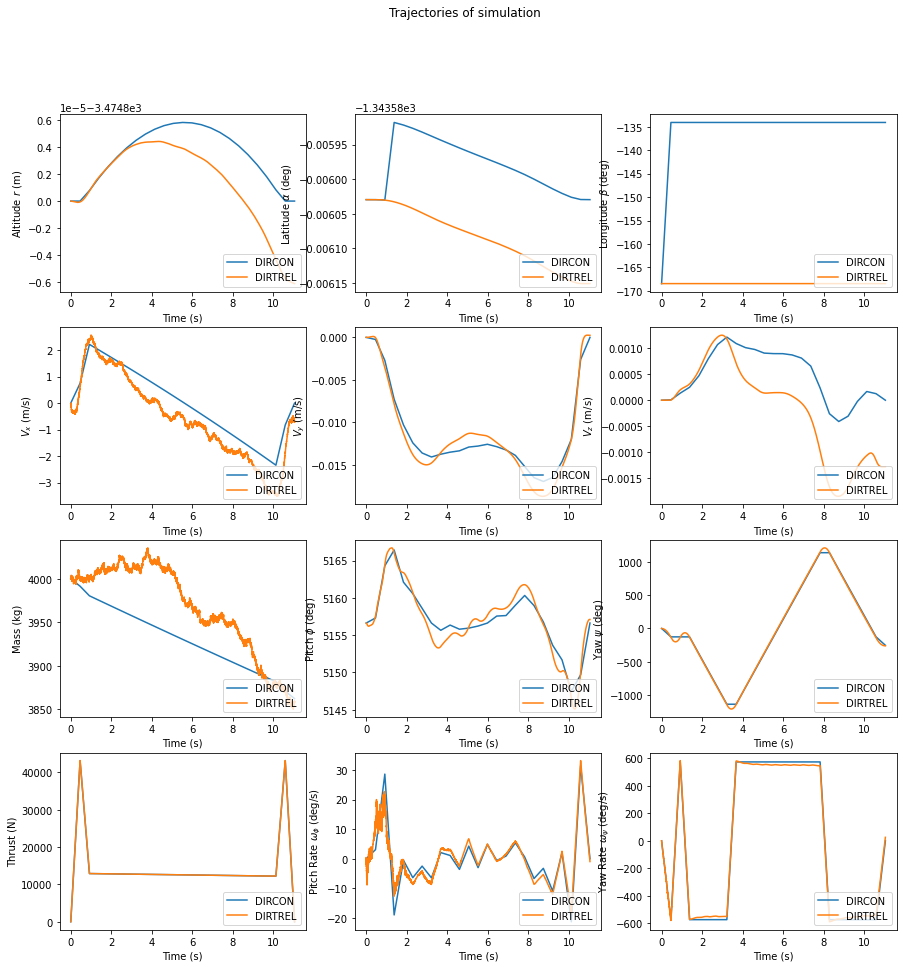

In [82]:
x_sim_plot = xsim
u_sim_plot = usim
x_sim_plot[:,0] -= r_min
x_sim_plot[:,0] /= 1000
x_sim_plot[:,1] *= 180/np.pi
x_sim_plot[:,2] *= 180/np.pi
x_sim_plot[:,7] *= 180/np.pi
x_sim_plot[:,8] *= 180/np.pi
u_sim_plot[:,1] *= 180/np.pi
u_sim_plot[:,2] *= 180/np.pi
plot_util_overlay(timesteps, x_sol_plot, u_sol_plot,tsim,x_sim_plot,u_sim_plot,n_x)

In [ ]:
plt.plot(tsim, xsim[:,1], label='TVLQR')
plt.plot(timesteps, x_sol[:,1])
plt.xlim(0, 200)
plt.xlim(0,30)
plt.legend()

# x = [r, alpha, beta, vx, vy, vz, m, phi, psi]
# u = [T, w_phi, w_psi]